In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import glob
import numpy
from scipy import ndimage, signal
import matplotlib
matplotlib.use('PDF')
from galpy.util import bovy_conversion, bovy_plot
import gd1_util
from gd1_util import R0, V0
import seaborn as sns
from matplotlib import cm, pyplot
from matplotlib.ticker import FuncFormatter, NullFormatter
%pylab inline
scaling= 'spectrum'
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Analysis of simulations with stream peppering for a GD-1 like stream

In [3]:
sdf_smooth= gd1_util.setup_gd1model()
print "Stream length in arc degree and physical kpc", sdf_smooth.length(ang=True), sdf_smooth.length(phys=True)

Stream length in arc degree and physical kpc 93.2298795945 12.3709237227


In [4]:
def median_csd(filename,filename2=None,scatter=False):
    # Compute the median CSD, if filename2 is not None, compute cross
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    if filename2 is None:
        data2= data1
    else:
        data2= numpy.genfromtxt(filename2,delimiter=',',max_rows=5002)
        # Search for batches
        batchfilenames= glob.glob(filename2.replace('.dat','.*.dat'))
        for bfilename in batchfilenames:
            try:
                datab= numpy.genfromtxt(bfilename,delimiter=',')
            except: continue
            data2= numpy.vstack((data2,datab[2:]))
    apars= data1[0]
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print "WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename)
    px= signal.csd(data1[1],data2[1],fs=1./(apars[1]-apars[0]),scaling=scaling)[0]
    ppy= numpy.empty((nsim,len(px)))
    for ii in range(nsim):
        if numpy.any(data1 != data2):
            ppy[ii]= numpy.absolute(signal.csd(data1[2+ii]/data1[1],data2[2+ii]/data2[1],
                                               fs=1./(apars[1]-apars[0]),scaling=scaling)[1])
        else:
            ppy[ii]= signal.csd(data1[2+ii]/data1[1],data1[2+ii]/data1[1],
                                fs=1./(apars[1]-apars[0]),scaling=scaling)[1].real
    # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
    if not scatter:
        return (180./px/numpy.pi,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(apars[-1]-apars[0])))
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(apars[-1]-apars[0]))
        ppy.sort(axis=0)
        return (180./px/numpy.pi,out,
                numpy.sqrt(ppy[int(numpy.round(0.25*nsim))]*(apars[-1]-apars[0])),
                numpy.sqrt(ppy[int(numpy.round(0.75*nsim))]*(apars[-1]-apars[0])))

In [5]:
def plot_all(filename,color=sns.color_palette()[0],zorder=1,ls='-',
            fill=False,fill_color='0.65',fill_zorder=0,
            scale=1.):
    subplot(1,3,1)
    px, py= median_csd(filename)
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if fill:
        plotx, dum, low, high= median_csd(filename,scatter=True)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,2)
    px, py= median_csd(filename.replace('dens','omega'))
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if fill:
        plotx, dum, low, high= median_csd(filename.replace('dens','omega'),scatter=True)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    subplot(1,3,3)
    px, py= median_csd(filename,filename.replace('dens','omega'))
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls)
    if fill:
        plotx, dum, low, high= median_csd(filename,filename.replace('dens','omega'),scatter=True)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None
def set_ranges_and_labels():
    subplot(1,3,1)
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$180/\pi/k_{\theta}\,(\mathrm{deg})$')
    ylim(0.0001,1.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    subplot(1,3,2)
    bovy_plot.bovy_text(r'$\sqrt{\Omega\Omega}$',top_left=True,size=18.)
    xlabel(r'$180/\pi/k_{\theta}\,(\mathrm{deg})$')
    ylim(0.0001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    subplot(1,3,3)
    bovy_plot.bovy_text(r'$\sqrt{|\delta\Omega|}$',top_left=True,size=18.)
    xlabel(r'$180/\pi/k_{\theta}\,(\mathrm{deg})$')
    ylim(0.0001,1.)
    xlim(1.,100.)
    gca().xaxis.set_major_formatter(FuncFormatter(
            lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    gca().yaxis.set_major_formatter(NullFormatter())
    return None
def color_from_colormap(val,cmap,cmin,cmax):
    return cmap((val-cmin)/(cmax-cmin))
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025, 0.83])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



## Single times

In [6]:
basefilename= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','gd1_onetime')

Spaced 1 Gyr apart

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 202, using nperseg = 202
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 138, using nperseg = 138
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 74, using nperseg = 74
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))



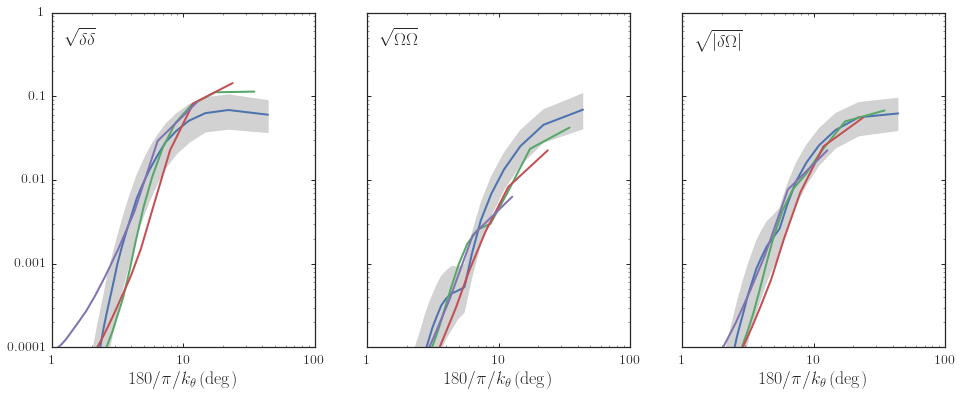

In [7]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t1.0_6.5_dens.dat'),
         color=sns.color_palette()[0],zorder=6,fill=True)
plot_all(os.path.join(basefilename,'gd1_t2.0_6.5_dens.dat'),
         color=sns.color_palette()[1],zorder=6)
plot_all(os.path.join(basefilename,'gd1_t3.0_6.5_dens.dat'),
         color=sns.color_palette()[2],zorder=6)
plot_all(os.path.join(basefilename,'gd1_t4.0_6.5_dens.dat'),
         color=sns.color_palette()[3],zorder=6)
set_ranges_and_labels()

Impacts near pericenter, near apocenter, and in between [radial period is $\approx400$ Myr]:

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 125, using nperseg = 125
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 137, using nperseg = 137
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 131, using nperseg = 131
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



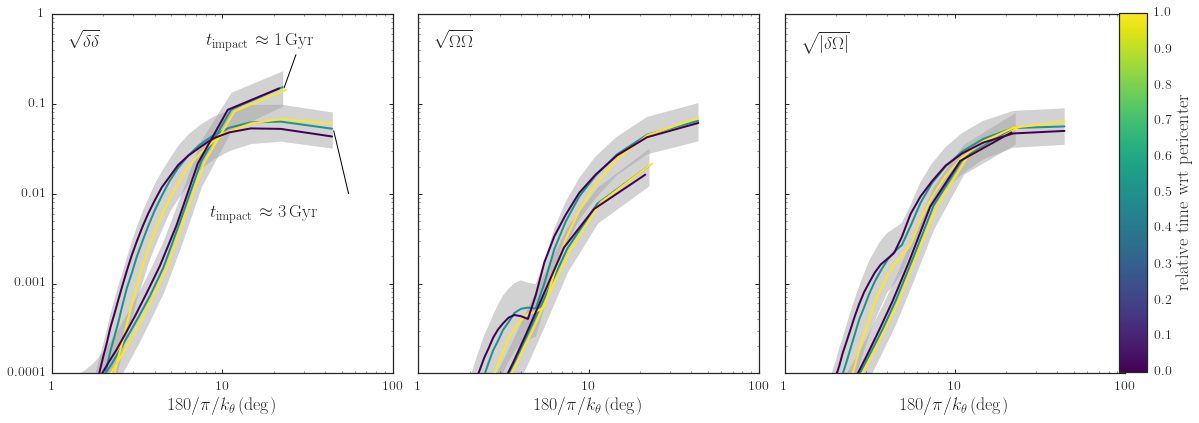

In [8]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
cmap= cm.viridis
plot_all(os.path.join(basefilename,'gd1_t0.81peri_6.5_dens.dat'),
         color=color_from_colormap(0.,cmap,0.,1.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t3.21peri_6.5_dens.dat'),
         color=color_from_colormap(0.,cmap,0.,1.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t1.01apo_6.5_dens.dat'),
         color=color_from_colormap(1.,cmap,0.,1.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t3.01apo_6.5_dens.dat'),
         color=color_from_colormap(1.,cmap,0.,1.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t0.9between_6.5_dens.dat'),
         color=color_from_colormap(0.5,cmap,0.,1.),zorder=3,fill=True)
plot_all(os.path.join(basefilename,'gd1_t3.1between_6.5_dens.dat'),
         color=color_from_colormap(0.5,cmap,0.,1.),zorder=3,fill=True)
set_ranges_and_labels()
# Annotate
subplot(1,3,1)
plot([23.,27],[0.15,0.35],'k-',lw=1.)
bovy_plot.bovy_text(8.,0.4,r'$t_{\mathrm{impact}} \approx 1\,\mathrm{Gyr}$',size=18.)
plot([45.,55.],[0.05,0.01],'k-',lw=1.)
bovy_plot.bovy_text(8.5,0.005,r'$t_{\mathrm{impact}} \approx 3\,\mathrm{Gyr}$',size=18.)
# Add colorbar
add_colorbar(0,1,r'$\mathrm{relative\ time\ wrt\ pericenter}$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_periapobetween.pdf'))
else:
    tight_layout()

Same for $M=10^{5.5}\,M_\odot$:

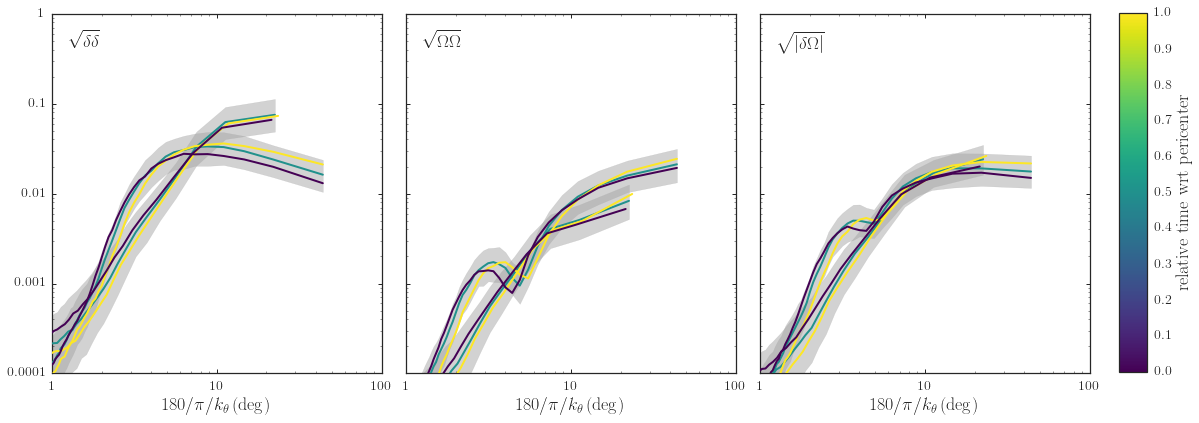

In [9]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.viridis
plot_all(os.path.join(basefilename,'gd1_t0.81peri_5.5_dens.dat'),
         color=color_from_colormap(0.,cmap,0.,1.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t3.21peri_5.5_dens.dat'),
         color=color_from_colormap(0.,cmap,0.,1.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t1.01apo_5.5_dens.dat'),
         color=color_from_colormap(1.,cmap,0.,1.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t3.01apo_5.5_dens.dat'),
         color=color_from_colormap(1.,cmap,0.,1.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t0.9between_5.5_dens.dat'),
         color=color_from_colormap(0.5,cmap,0.,1.),zorder=3,fill=True)
plot_all(os.path.join(basefilename,'gd1_t3.1between_5.5_dens.dat'),
         color=color_from_colormap(0.5,cmap,0.,1.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
# Add colorbar
add_colorbar(0,1,r'$\mathrm{relative\ time\ wrt\ pericenter}$')

## Multiple times

How finely do we have to sample the impact-time grid to get statistically similar results? For $M=10^{6.5}\,M_\odot$:

In [10]:
basefilename= os.path.join(os.getenv('DATADIR'),'streamgap-pepper','gd1_multtime')

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 42, using nperseg = 42
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/scipy/signal/spectral.py:767: UserWarning: nperseg = 256, is greater than input length = 215, using nperseg = 215
  'using nperseg = {1:d}'.format(nperseg, x.shape[-1]))



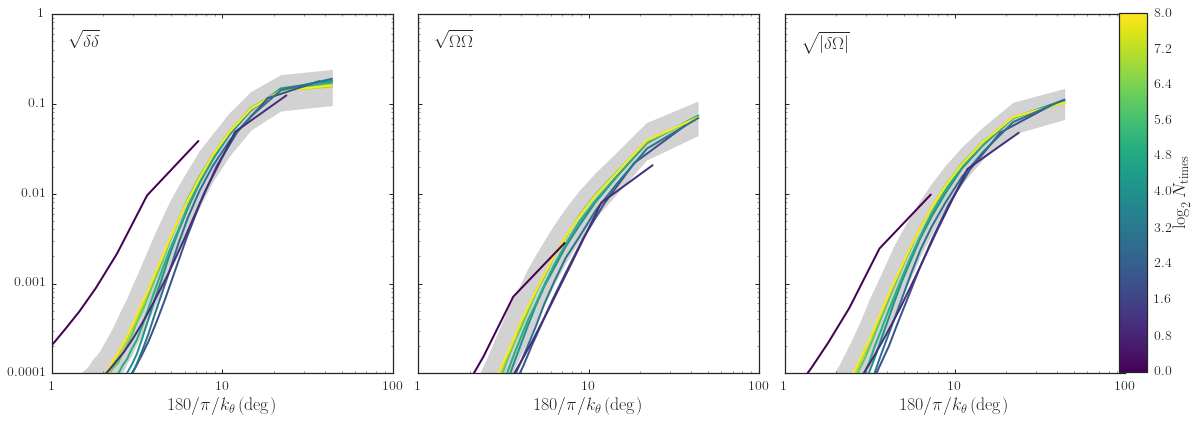

In [11]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t1sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(0,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t2sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t4sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(2,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t8sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t16sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(4,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t32sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t128sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(7,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(8,cmap,0.,8.),zorder=3,fill=True)
set_ranges_and_labels()
add_colorbar(0,8,r'$\log_2 N_{\mathrm{times}}$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_6p5timesampling.pdf'))
else:
    tight_layout()

Same for $10^{5.5}\,M_\odot$:

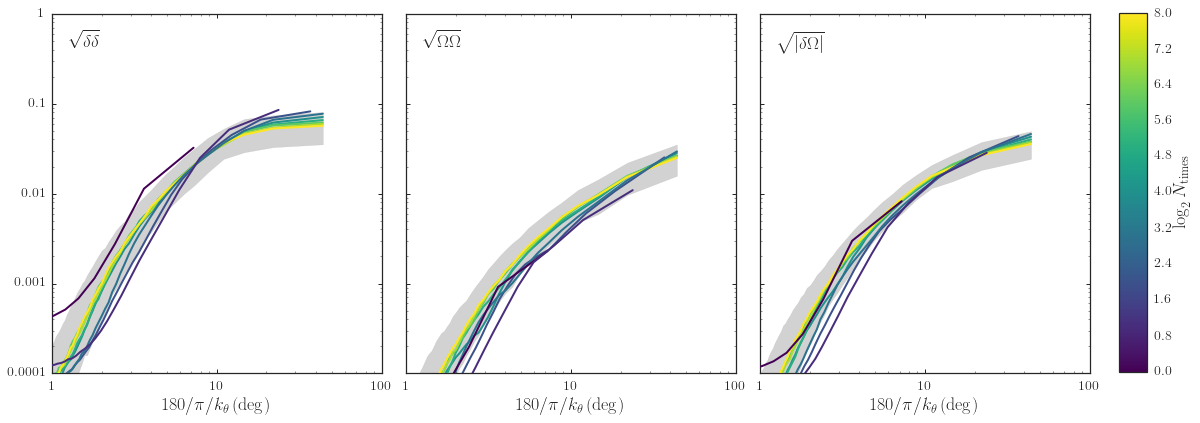

In [12]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t1sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(0,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t2sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t4sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(2,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t8sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t16sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(4,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t32sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(6,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t128sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(7,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(8,cmap,0.,8.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
add_colorbar(0,8,r'$\log_2 N_{\mathrm{times}}$')

Same for $10^{7.5}\,M_\odot$:

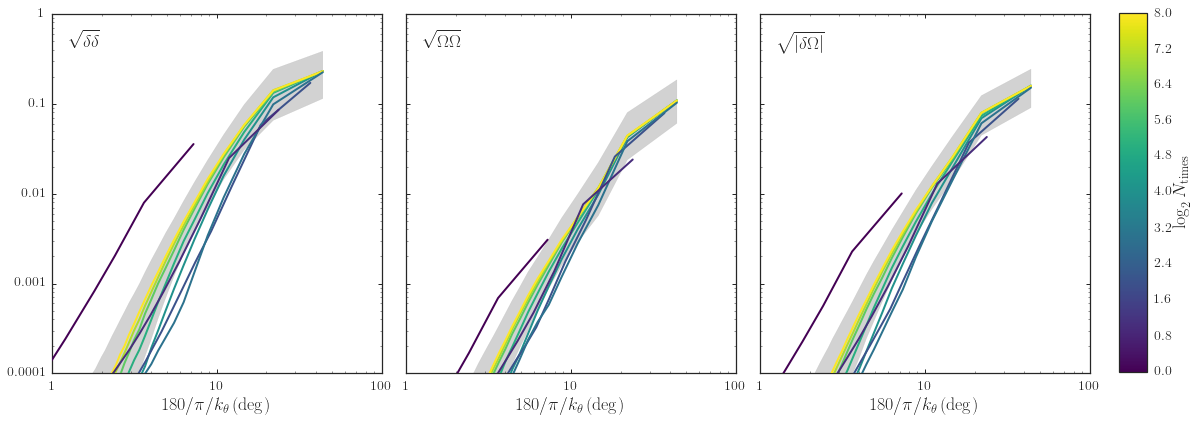

In [13]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t1sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(0,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t2sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,8.),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t4sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(2,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t8sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,8.),zorder=4)
plot_all(os.path.join(basefilename,'gd1_t16sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(4,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t32sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(6,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t128sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7,cmap,0.,8.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(8,cmap,0.,8.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
add_colorbar(0,8,r'$\log_2 N_{\mathrm{times}}$')

Comparing the effects of different mass ranges

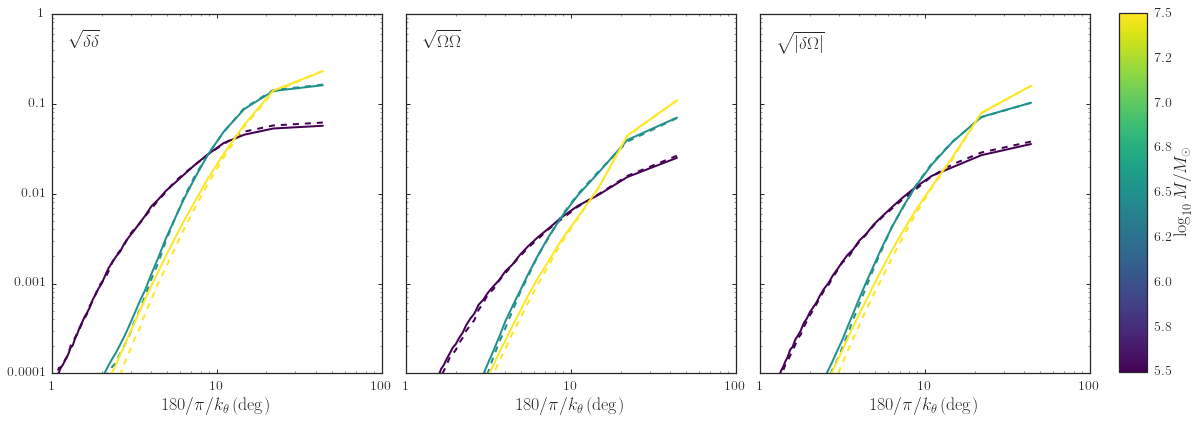

In [14]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=5,ls='--')
set_ranges_and_labels()
tight_layout()
add_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$')

## Maximum impact parameter

How many times the scale radius do we need to consider for the impact parameter? We fix the number of potential impact times to 64 (which seems close to converged, see above). For $10^{6.5}\,M_\odot$:

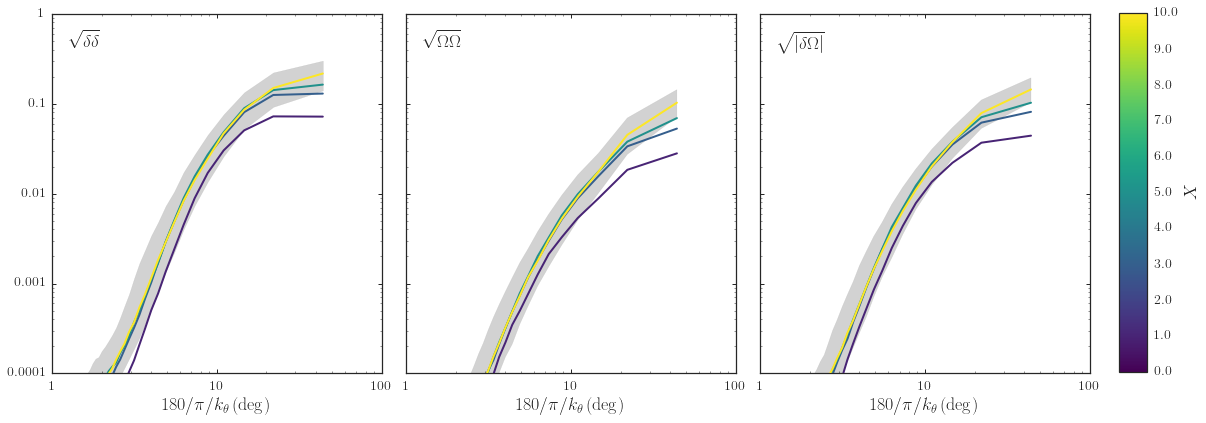

In [15]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_6.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X1_6.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_6.5_dens.dat'),
         color=color_from_colormap(10.,cmap,0.,10.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
add_colorbar(0,10,r'$X$')

Same for $10^{5.5}\,M_\odot$:

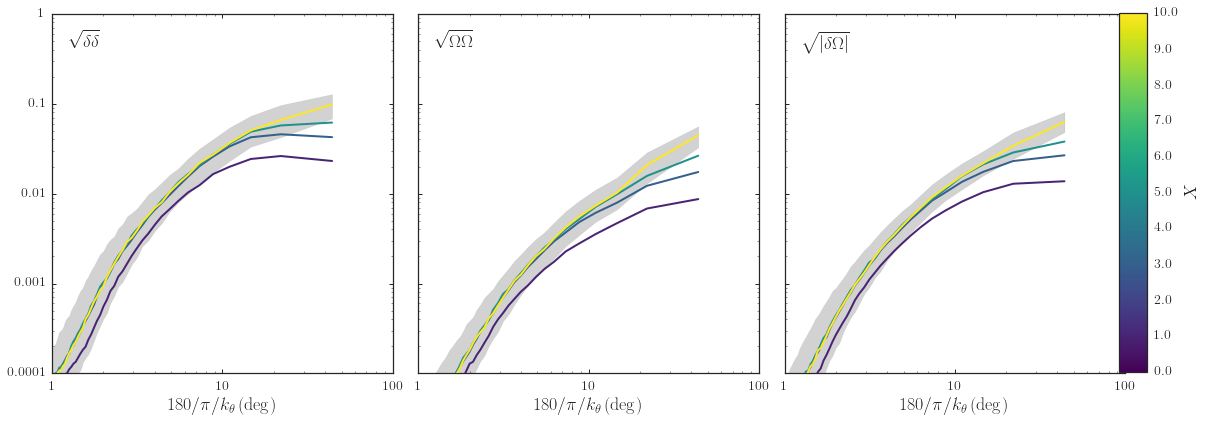

In [16]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_5.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X1_5.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_5.5_dens.dat'),
         color=color_from_colormap(10.,cmap,0.,10.),zorder=3,fill=True)
set_ranges_and_labels()
add_colorbar(0,10,r'$X$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_5p5bmax.pdf'))
else:
    tight_layout()

Same for $10^{7.5}\,M_\odot$:

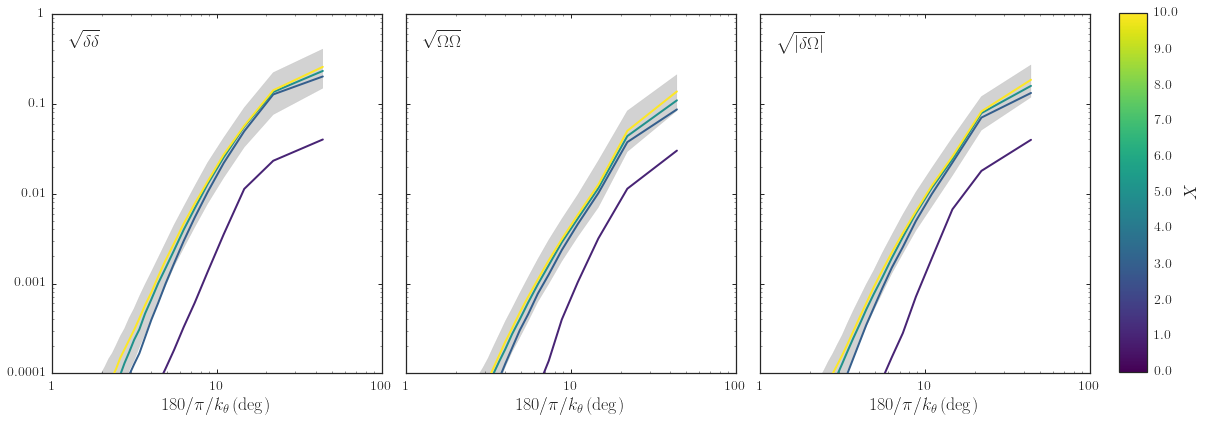

In [17]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_7.5_dens.dat'),
         color=color_from_colormap(3,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X1_7.5_dens.dat'),
         color=color_from_colormap(1,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(5,cmap,0.,10.),zorder=3)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_7.5_dens.dat'),
         color=color_from_colormap(10.,cmap,0.,10.),zorder=3,fill=True)
set_ranges_and_labels()
tight_layout()
add_colorbar(0,10,r'$X$')

Comparing the effects of different mass ranges

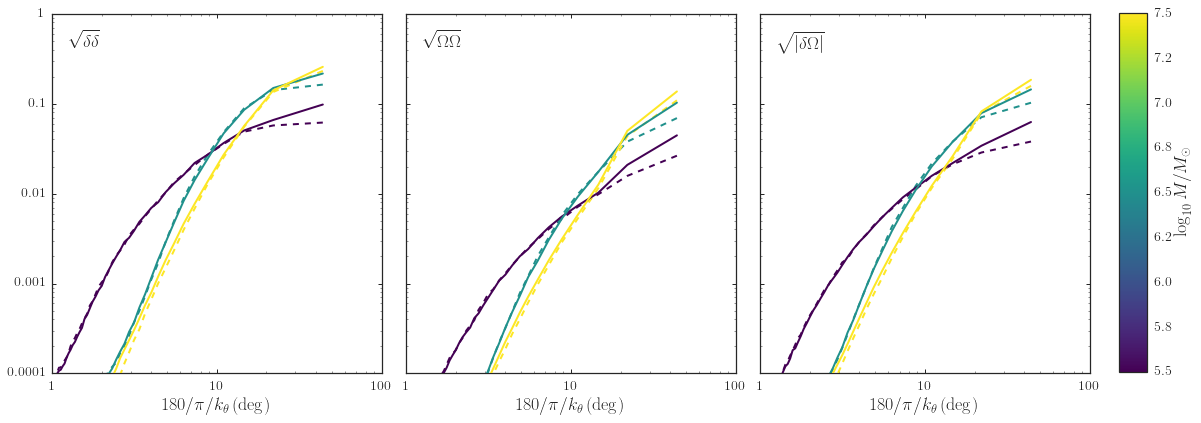

In [18]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=5,ls='--')
set_ranges_and_labels()
tight_layout()
add_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$')

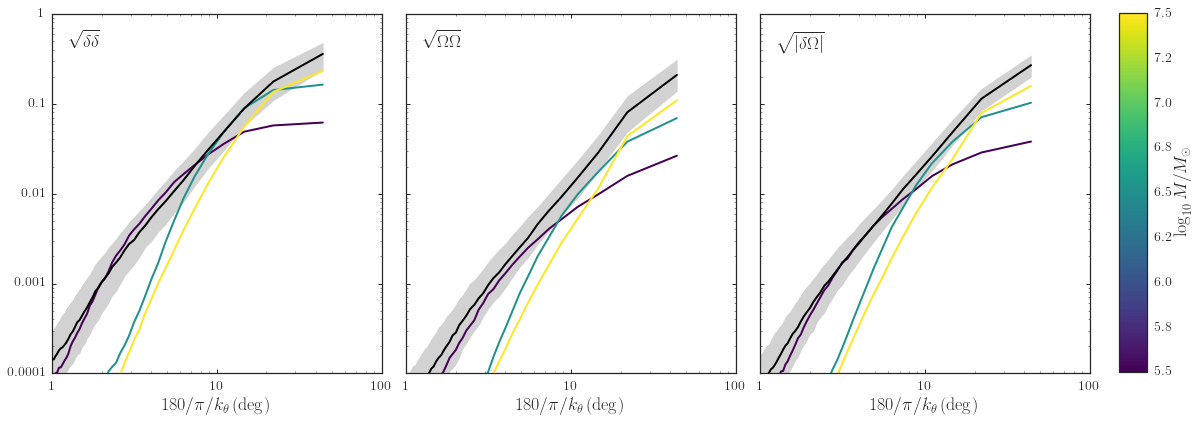

In [19]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),color='k',
        zorder=10,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=5)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=5)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=5)
set_ranges_and_labels()
tight_layout()
add_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$')

## bmax and time sampling approximations on the same figure

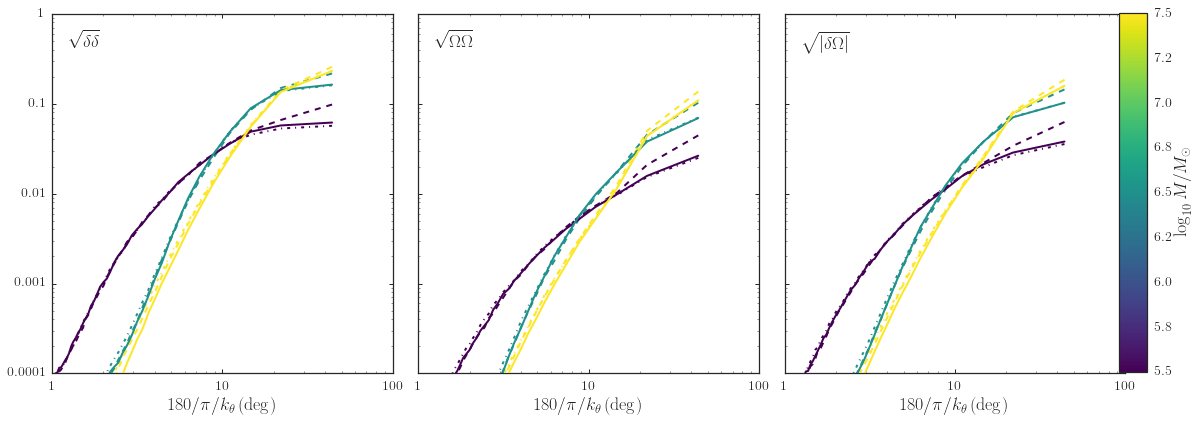

In [20]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
cmap= cm.viridis
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=6,ls='-.')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5.5_dens.dat'),
         color=color_from_colormap(5.5,cmap,5.5,7.5),zorder=7)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=6,ls='-.')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_6.5_dens.dat'),
         color=color_from_colormap(6.5,cmap,5.5,7.5),zorder=7)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X10_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=5,ls='--')
plot_all(os.path.join(basefilename,'gd1_t256sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=6,ls='-.')
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_7.5_dens.dat'),
         color=color_from_colormap(7.5,cmap,5.5,7.5),zorder=7)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(5.5,7.5,r'$\log_{10} M/M_\odot$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_bmaxtimesampling.pdf'))
else:
    tight_layout()

## Hernquist vs. Plummer

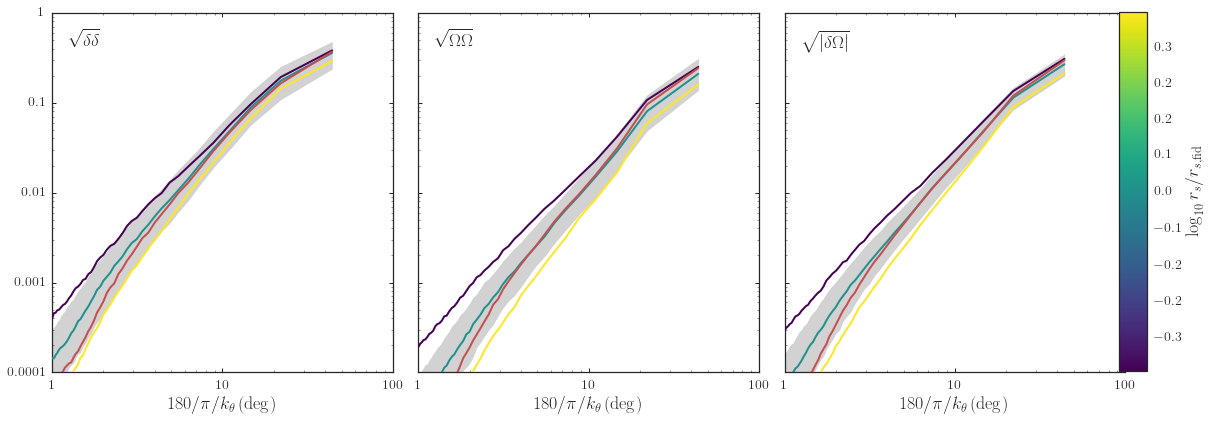

In [21]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.viridis
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(0.,cmap,numpy.log10(0.4),numpy.log10(2.5)),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X12p5_rsfacp4_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(0.4),cmap,numpy.log10(0.4),numpy.log10(2.5)),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X2_rsfac2p5_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(2.5),cmap,numpy.log10(0.4),numpy.log10(2.5)),zorder=10)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X3p24_plum_5-9_dens.dat'),
         color=sns.color_palette()[2],zorder=11)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(numpy.log10(0.4),numpy.log10(2.5),r'$\log_{10} r_s/r_{s,\mathrm{fid}}$',save_figures=save_figures)
if save_figures:
    subplot(1,3,1)
    plot([7.,12.],[0.000225,0.000225],color=sns.color_palette()[2],lw=2.)
    bovy_plot.bovy_text(15.,0.000175,r'$\mathrm{Plummer}$',size=18.)
    plot([7.,12.],[0.0005,0.00050625],color=color_from_colormap(numpy.log10(0.4),cmap,numpy.log10(0.4),numpy.log10(2.5)),
         lw=2.)
    plot([7.,12.],[0.00045,0.00045],color=color_from_colormap(numpy.log10(1.),cmap,numpy.log10(0.4),numpy.log10(2.5)),
         lw=2.)
    plot([7.,12.],[0.0004,0.0004],color=color_from_colormap(numpy.log10(2.5),cmap,numpy.log10(0.4),numpy.log10(2.5)),
         lw=2.)
    bovy_plot.bovy_text(15.,0.000375,r'$\mathrm{Hernquist}$',size=18.)
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_rsplummer.pdf'))
else:
    tight_layout()

## Rate = multiple of CDM prediction

Can we just scale the CDM prediction?

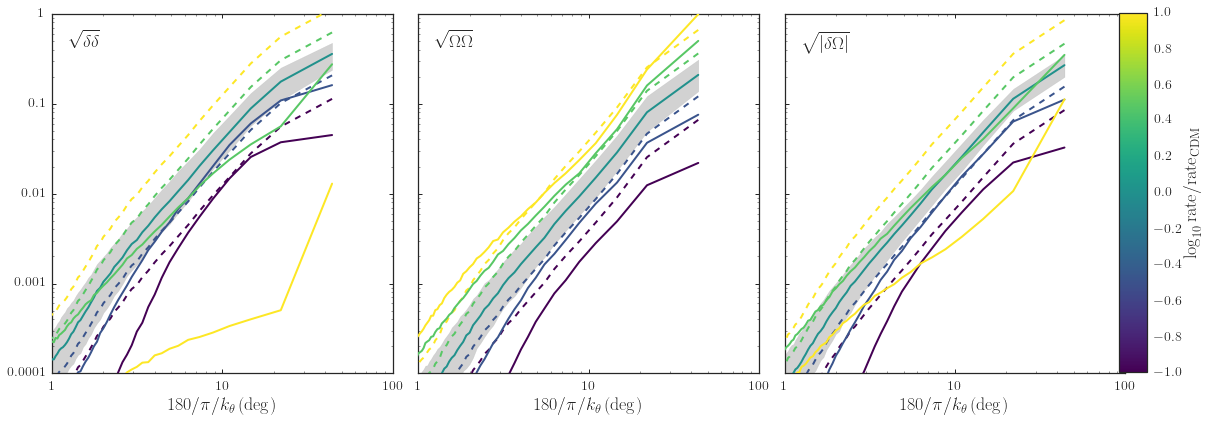

In [22]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.viridis
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(0.,cmap,-1,1.,),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cdmp33_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(0.333333),ls='--',
         color=color_from_colormap(numpy.log10(0.333333333),cmap,-1.,1.),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cdm3_5-9_dens.dat'),
         color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=10)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(3.),ls='--',
         color=color_from_colormap(numpy.log10(3.),cmap,-1.,1.),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cdmp1_5-9_dens.dat'),
         color=color_from_colormap(-1.,cmap,-1.,1.),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(0.1),ls='--',
         color=color_from_colormap(-1.,cmap,-1.,1.),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cdm10_5-9_dens.dat'),
         color=color_from_colormap(1.,cmap,-1.,1.),zorder=10)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(10.),ls='--',
         color=color_from_colormap(1.,cmap,-1.,1.),zorder=8)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(-1.,1.,r'$\log_{10} \mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_multcdm.pdf'))
else:
    tight_layout()

## Dependence on age

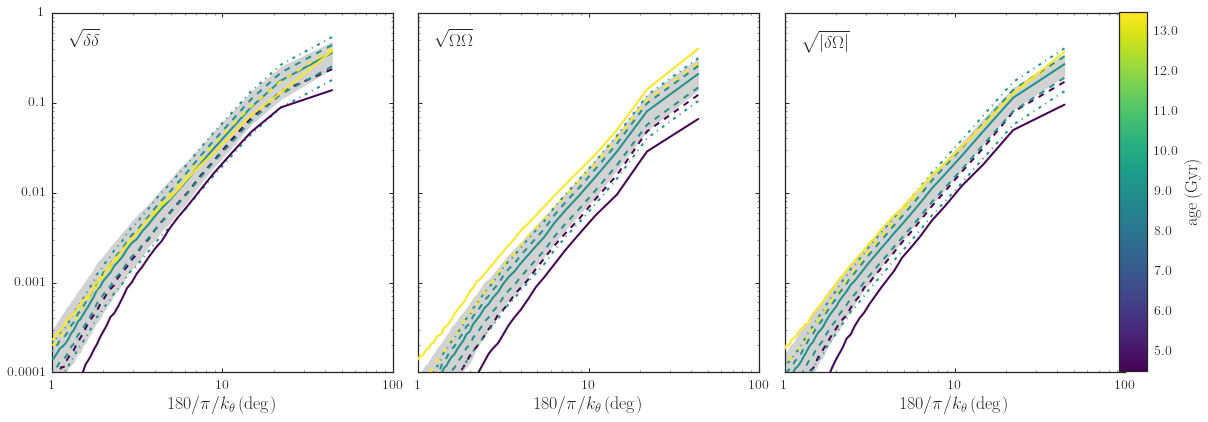

In [23]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.viridis
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_age4p5_5-9_dens.dat'),
         color=color_from_colormap(4.5,cmap,4.5,13.5),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_age4p5_cdm2_5-9_dens.dat'),ls='--',
         color=color_from_colormap(4.5,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(0.5),ls='--',
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=0.5,ls='-.',
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t96sampling_X5_age13p5_5-9_dens.dat'),
         color=color_from_colormap(13.5,cmap,4.5,13.5),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t96sampling_X5_age13p5_cdmp66_5-9_dens.dat'),ls='--',
         color=color_from_colormap(13.5,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=numpy.sqrt(1.5),ls='--',
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),scale=1.5,ls='-.',
         color=color_from_colormap(9.,cmap,4.5,13.5),zorder=8)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(4.5,13.5,r'$\mathrm{age}\,(\mathrm{Gyr})$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_age.pdf'))
else:
    tight_layout()

## CDM spectrum with cut-off

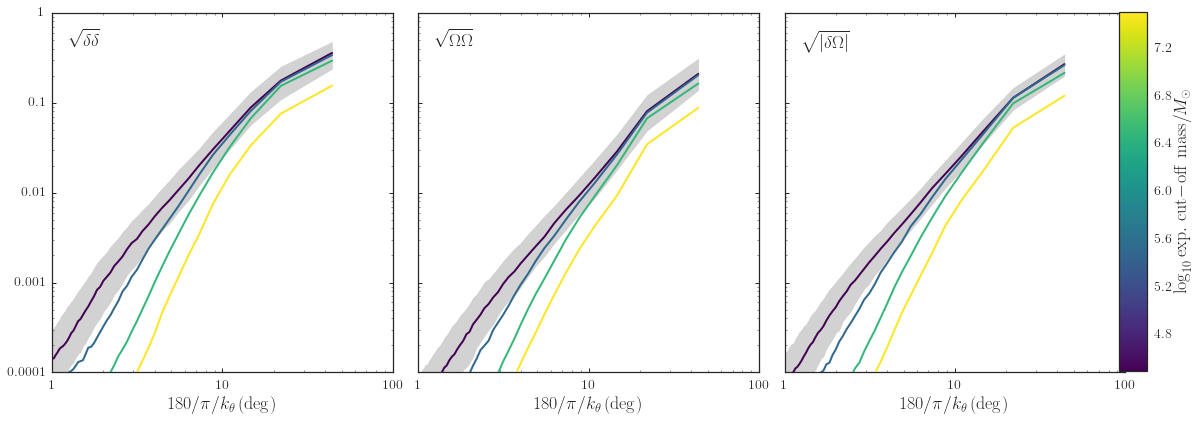

In [24]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.viridis
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(4.5,cmap,4.5,7.5),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cutoff5p5_5-9_dens.dat'),
         color=color_from_colormap(5.5,cmap,4.5,7.5),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cutoff6p5_5-9_dens.dat'),
         color=color_from_colormap(6.5,cmap,4.5,7.5),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_cutoff7p5_5-9_dens.dat'),
         color=color_from_colormap(7.5,cmap,4.5,7.5),zorder=9)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(4.5,7.5,r'$\log_{10} \mathrm{exp.\ cut\!-\!off\ mass} / M_\odot$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_cutoff.pdf'))
else:
    tight_layout()

## Different CDM spectrum

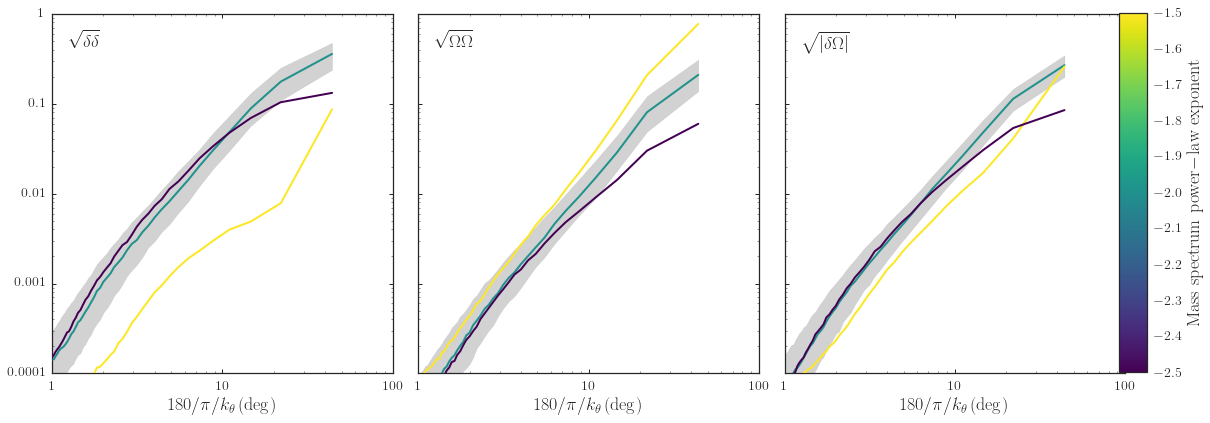

In [25]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(16,6)
cmap= cm.viridis
if save_figures:
    figsize(11,4.25)
    fig= figure()
    fig.subplots_adjust(left=0.065,right=0.8875,bottom=0.135,top=0.95,wspace=0.075)
else:
    figsize(16,6)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_5-9_dens.dat'),
         color=color_from_colormap(-2.,cmap,-2.5,-1.5),zorder=8,fill=True)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_massexpm1p5_5-9_dens.dat'),
         color=color_from_colormap(-1.5,cmap,-2.5,-1.5),zorder=9)
plot_all(os.path.join(basefilename,'gd1_t64sampling_X5_massexpm2p5_5-9_dens.dat'),
         color=color_from_colormap(-2.5,cmap,-2.5,-1.5),zorder=9)
set_ranges_and_labels()
if not save_figures: tight_layout()
add_colorbar(-2.5,-1.5,r'$\mathrm{Mass\ spectrum\ power\!-\!law\ exponent}$',save_figures=save_figures)
if save_figures:
    bovy_plot.bovy_end_print(os.path.join(os.getenv('PAPERSDIR'),'2016-stream-stats','gd1like_diffexp.pdf'))
else:
    tight_layout()